In [23]:
pip install segmentation-models-pytorch

In [24]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from torch.nn.functional import pad
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
class CustomCarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, target_size=(1280, 960), transform=None):
        """
        Args:
            images_dir (str): Directory with all the images.
            masks_dir (str): Directory with all the masks.
            target_size (tuple): Target size for resizing (width, height).
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.transform = transform

        # Load image and mask files
        self.image_files = sorted(glob.glob(os.path.join(images_dir, '**', '*'), recursive=True))
        self.image_files = [f for f in self.image_files if f.lower().endswith(('.jpg', '.jpeg', '.JPG'))]

        self.mask_files = sorted(glob.glob(os.path.join(masks_dir, '**', '*'), recursive=True))
        self.mask_files = [f for f in self.mask_files if f.lower().endswith('.png')]

        print(f"Number of image files: {len(self.image_files)}")
        print(f"Number of mask files: {len(self.mask_files)}")

        # Ensure there are matching numbers of images and masks
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks count."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply resizing to both image and mask
        resize_transform = transforms.Resize(self.target_size)
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Apply additional transform to image if specified
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)  # Convert image to tensor if no transform is specified

        # Convert mask to tensor
        mask = transforms.ToTensor()(mask)

        return image, mask


In [27]:
images_dir = "/content/drive/MyDrive/project/image/data/images"  # importing the dataset for original images
masks_dir = "/content/drive/MyDrive/project/image/data/mask"   # importing the mask dataset for mask images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomCarvanaDataset(images_dir=images_dir, masks_dir=masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)


Number of image files: 207
Number of mask files: 207


In [28]:
# Instantiate dataset
train_dataset = CustomCarvanaDataset(images_dir=images_dir, masks_dir=masks_dir, target_size=(1280, 960))

# DataLoader with batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


Number of image files: 207
Number of mask files: 207


# New Section

In [29]:
# Calculate sizes for the splits
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.11 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # Remaining 10% for testing

# Randomly split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Print sizes to verify
print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 207
Training set size: 165
Validation set size: 22
Test set size: 20


In [30]:
# Initialize the model
model = smp.Unet(
    encoder_name="vgg16",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

# Load the pre-trained model weights
model_path = r'/content/drive/MyDrive/project/image/data/model/unet_carvana_scale1.0_epoch2 (2).pth'  # Replace with your model file path

# Check if the model file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")

# Check if the model file size is reasonable (not too small)
file_size = os.path.getsize(model_path)
if file_size < 1000000:  # Adjust the threshold as needed
    raise ValueError(f"Model file size is too small: {file_size} bytes. It might be corrupted.")

# Load the model state dictionary
try:
    # Load the saved state_dict
    state_dict = torch.load(model_path)

    # Filter out unexpected keys
    model_state_dict = model.state_dict()
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

    # Load the filtered state_dict into the model
    model.load_state_dict(filtered_state_dict, strict=False)  # strict=False to ignore missing keys

except RuntimeError as e:
    if "failed finding central directory" in str(e):
        raise RuntimeError(f"Model file might be corrupted: {model_path}") from e
    raise

# Set the model to evaluation mode (important for inference)
model.eval()

# Verify by printing the model architecture
print(model)

<ipython-input-30-dcfab5f3bae7>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [31]:
# Number of classes in the dataset
num_classes = 3


model.segmentation_head[0] = nn.Conv2d(in_channels=model.segmentation_head[0].in_channels,
                                             out_channels=3, kernel_size=1)

In [32]:
# Initialize the model (assuming this has been done previously)
model = smp.Unet(
    encoder_name="vgg16",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

# 1. Print the model's architecture
print(model)

# 2. Inspect the segmentation_head
print(model.segmentation_head)

# 3. Get the number of layers within segmentation_head
num_layers_in_segmentation_head = len(model.segmentation_head)
print(f"Number of layers in segmentation_head: {num_layers_in_segmentation_head}")

# 4. (Optional) Check the types of layers within segmentation_head
for i, layer in enumerate(model.segmentation_head):
    print(f"Layer {i}: {type(layer)}")

# checking the no of classes in output layer
num_classes = model.segmentation_head[0].out_channels
print(f"Number of output classes: {num_classes}")

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [33]:
for name, param in model.named_parameters():
    if "segmentation_head.0" in name:
        param.requires_grad = True  # Enable training for output layer
    else:
        param.requires_grad = False  # Freeze all other layers


In [34]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


encoder.features.0.weight: requires_grad=False
encoder.features.0.bias: requires_grad=False
encoder.features.2.weight: requires_grad=False
encoder.features.2.bias: requires_grad=False
encoder.features.5.weight: requires_grad=False
encoder.features.5.bias: requires_grad=False
encoder.features.7.weight: requires_grad=False
encoder.features.7.bias: requires_grad=False
encoder.features.10.weight: requires_grad=False
encoder.features.10.bias: requires_grad=False
encoder.features.12.weight: requires_grad=False
encoder.features.12.bias: requires_grad=False
encoder.features.14.weight: requires_grad=False
encoder.features.14.bias: requires_grad=False
encoder.features.17.weight: requires_grad=False
encoder.features.17.bias: requires_grad=False
encoder.features.19.weight: requires_grad=False
encoder.features.19.bias: requires_grad=False
encoder.features.21.weight: requires_grad=False
encoder.features.21.bias: requires_grad=False
encoder.features.24.weight: requires_grad=False
encoder.features.24.

In [35]:
print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")


Trainable Parameters:
segmentation_head.0.weight is trainable
segmentation_head.0.bias is trainable


In [36]:
# Assume you have a DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Function to evaluate performance
def evaluate_model(model, data_loader, device):
    # ... (other parts of your function) ...

    # Initialize total_loss, iou_score, and dice_score to 0
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    num_batches = len(data_loader)  # Calculate the number of batches

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Reshape the masks to 3 dimensions (N, H, W)
            masks = masks.squeeze(1)  # Remove the channel dimension

            # Resize outputs to match target mask dimensions
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # ***CHANGE***: Convert masks to Long type before calculating loss
            masks = masks.long()

            # Now calculate the loss
            loss = F.cross_entropy(outputs, masks)

            # Accumulate loss
            total_loss += loss.item()

            # Calculate IoU and Dice score
            preds = torch.argmax(outputs, dim=1)
            intersection = (preds & masks).float().sum((1, 2))
            union = (preds | masks).float().sum((1, 2))
            iou_score += (intersection / union).mean().item()

            dice_score += (2 * intersection / (preds.float().sum((1, 2)) + masks.float().sum((1, 2)))).mean().item()

    avg_loss = total_loss / num_batches
    avg_iou = iou_score / num_batches
    avg_dice = dice_score / num_batches

    return avg_loss, avg_iou, avg_dice

# Set device
device = torch.device('cuda')
model.to(device)

# Evaluate on training data
train_loss, train_iou, train_dice = evaluate_model(model, train_loader, device)
print(f"Training Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")

# Evaluate on validation data
val_loss, val_iou, val_dice = evaluate_model(model, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

Training Loss: 1.2091, IoU: 0.0596, Dice: 0.1074
Validation Loss: 1.2153, IoU: 0.0558, Dice: 0.1024


Epoch 1/10
Train Loss: 0.5556, IoU: 0.0203, Dice: 0.0391
Validation Loss: 0.5659, IoU: 0.0166, Dice: 0.0323
----------------------------------------
Epoch 2/10
Train Loss: 0.3998, IoU: 0.0016, Dice: 0.0032
Validation Loss: 0.4076, IoU: 0.0015, Dice: 0.0030
----------------------------------------
Epoch 3/10
Train Loss: 0.4067, IoU: nan, Dice: nan
Validation Loss: 0.4197, IoU: nan, Dice: nan
----------------------------------------
Epoch 4/10
Train Loss: 0.4099, IoU: 0.0082, Dice: 0.0160
Validation Loss: 0.4202, IoU: 0.0082, Dice: 0.0160
----------------------------------------
Epoch 5/10
Train Loss: 0.4032, IoU: nan, Dice: nan
Validation Loss: 0.4156, IoU: 0.0001, Dice: 0.0001
----------------------------------------
Epoch 6/10
Train Loss: 0.4026, IoU: 0.0361, Dice: 0.0663
Validation Loss: 0.4138, IoU: 0.0277, Dice: 0.0529
----------------------------------------
Epoch 7/10
Train Loss: 0.5307, IoU: 0.0605, Dice: 0.1110
Validation Loss: 0.5417, IoU: 0.0531, Dice: 0.0989
----------------

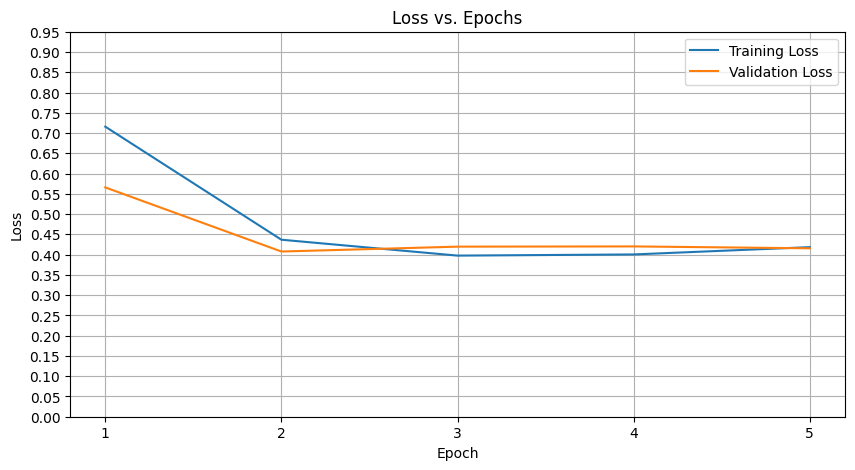

<Figure size 640x480 with 0 Axes>

In [37]:
import numpy as np
def train_model(model, train_loader, val_loader, optimizer, device, epochs=10):
    train_losses = []  # List to store training losses
    val_losses = []
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            masks = masks.squeeze(1)  # Remove channel dimension if necessary

            # Resize outputs to match target mask dimensions
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Calculate loss
            loss = F.cross_entropy(outputs, masks.long())  # Convert masks to Long
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on training and validation data
        train_loss, train_iou, train_dice = evaluate_model(model, train_loader, device)
        val_loss, val_iou, val_dice = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")
        print("-" * 40)
      # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 6), train_losses[:5], label='Training Loss')
    plt.plot(range(1, 6), val_losses[:5], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 6))  # Set x-axis ticks to integers
    plt.yticks(np.arange(0,1,0.05))  # Set x-axis ticks to integers

    plt.legend()
    plt.grid()
    plt.show()

    plt.savefig('lr6e-2.png')


# Set device and optimizer
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=6e-2)  # Define optimizer

# Train the model
train_model(model, train_loader, val_loader, optimizer, device, epochs=10)

In [38]:
def calculate_average_loss(model, data_loader, device):
    total_loss = 0.0
    num_batches = len(data_loader)
    model.eval()
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Ensure masks have the correct number of dimensions for interpolation
            if masks.dim() == 4 and masks.shape[1] == 1:  # If masks have an extra channel dimension
                masks = masks.squeeze(1)  # Remove the channel dimension

            # Resize outputs to match target mask dimensions
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = F.cross_entropy(outputs, masks.long())
            total_loss += loss.item()
    avg_loss = total_loss / num_batches
    return avg_loss

# Define device
device = torch.device('cuda')

try:
    # Load model and data from notebook context
    avg_train_loss = calculate_average_loss(model, train_loader, device)
    avg_val_loss = calculate_average_loss(model, val_loader, device)
    avg_train_loss, avg_val_loss
except NameError as e:
    # If the model or dataloaders are not defined in the notebook, indicate the missing definitions.
    str(e)


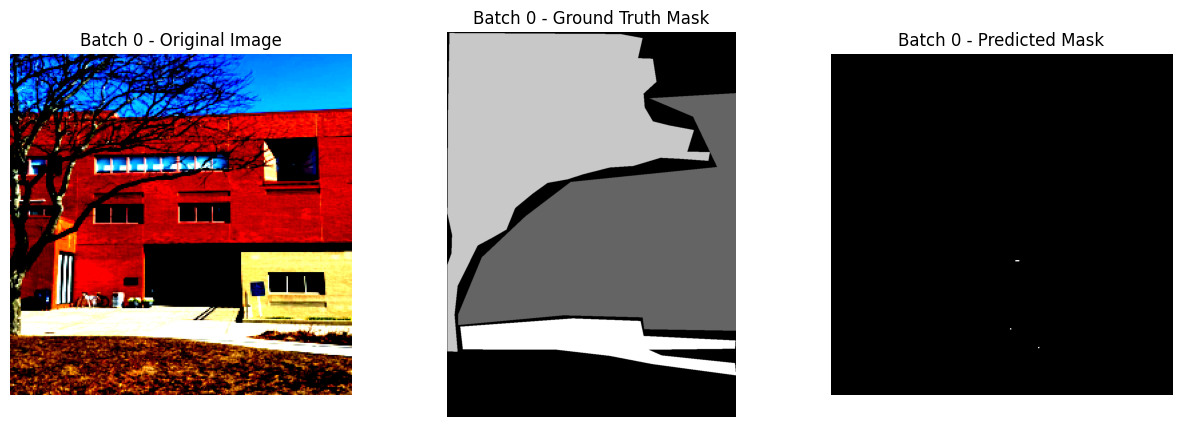

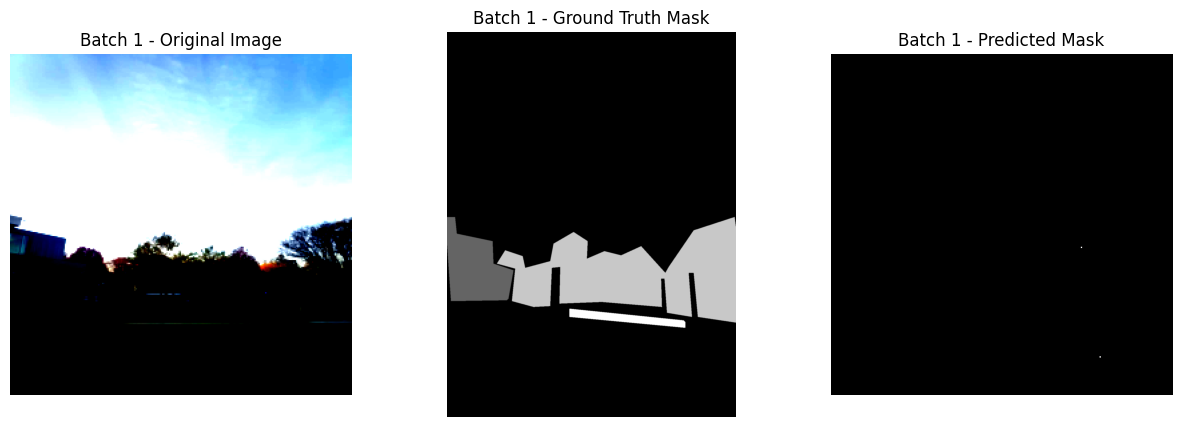

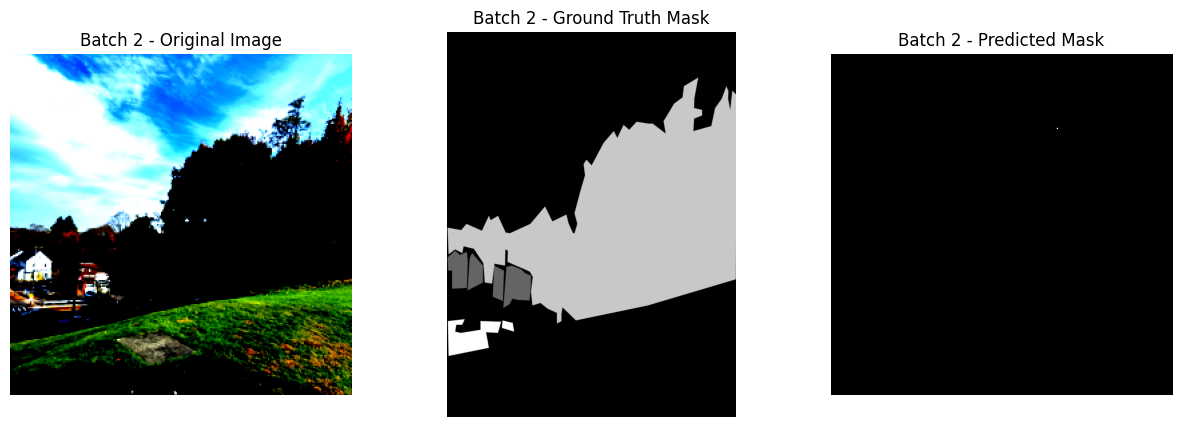

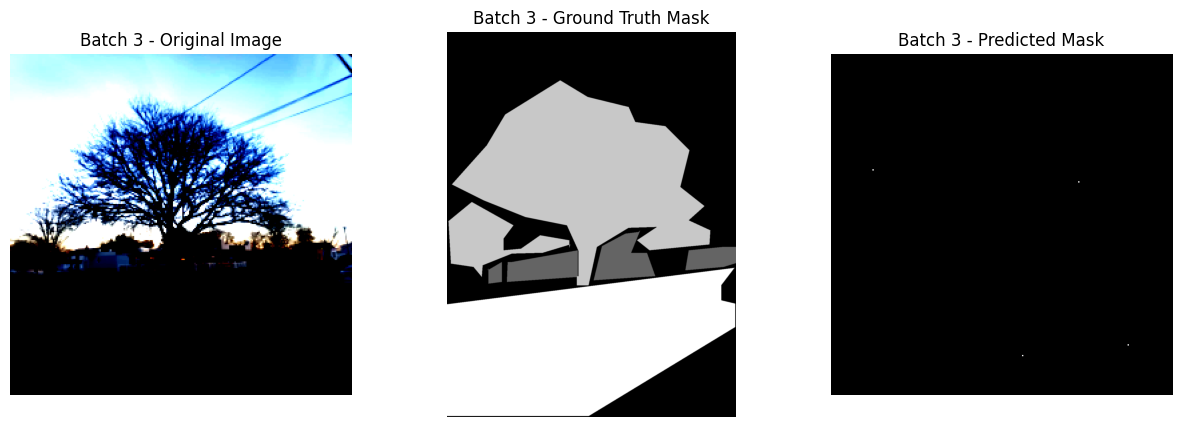

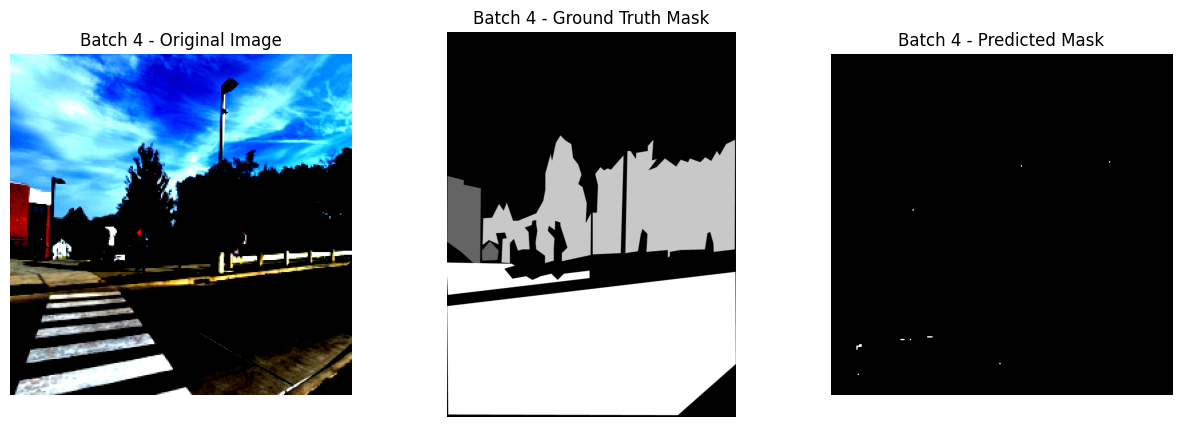

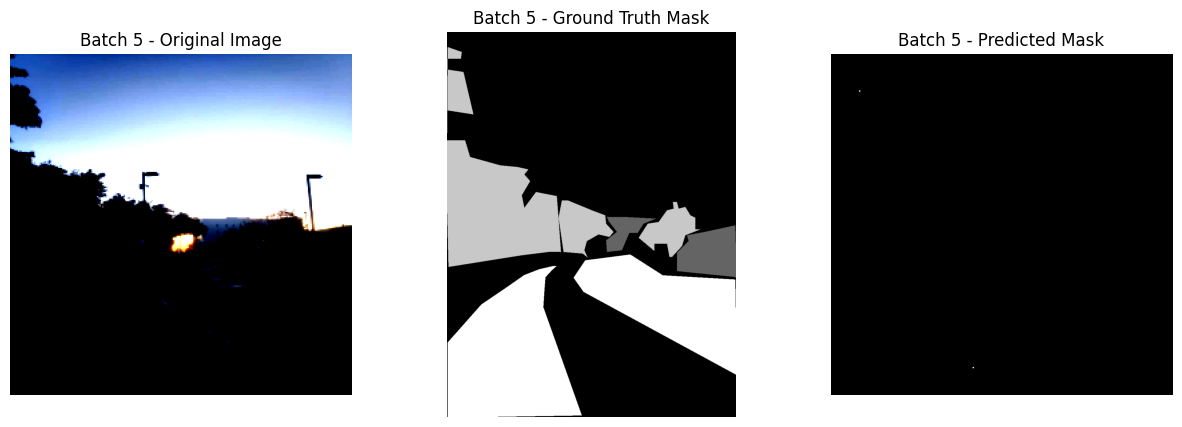

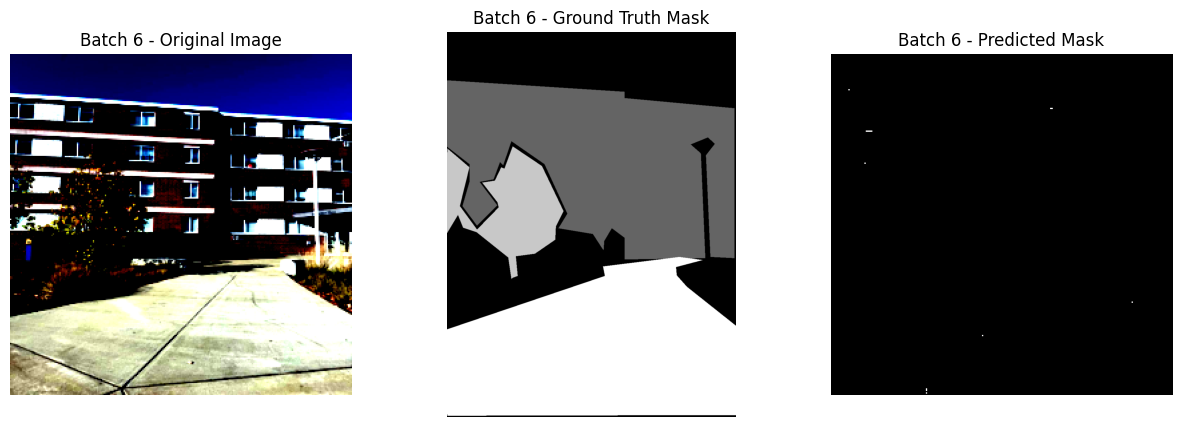

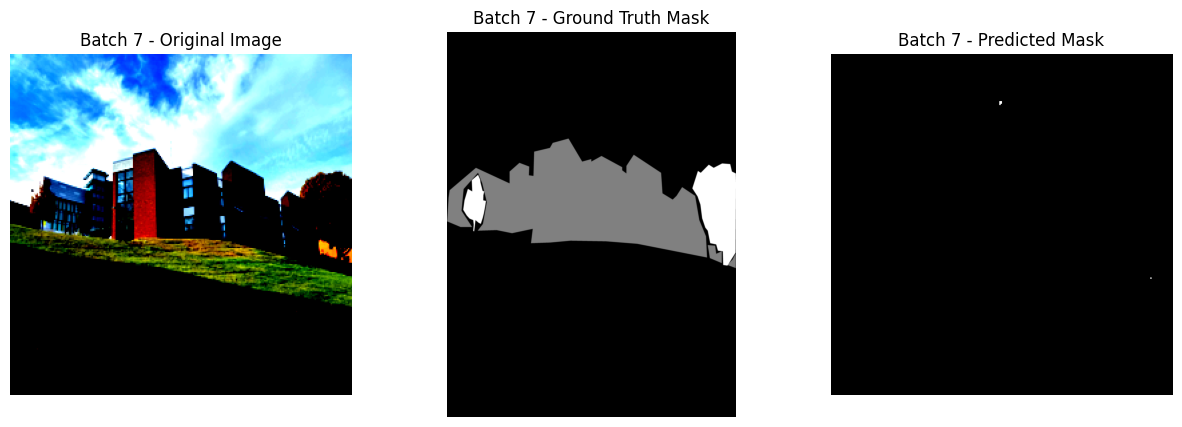

In [39]:

model.eval()

# Define a function to display image, ground truth, and prediction
def visualize_sample(image, mask, prediction, batch_idx):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title(f"Batch {batch_idx} - Original Image")

    # Squeeze the mask to remove the channel dimension before displaying
    axs[1].imshow(mask.squeeze(0).cpu().numpy(), cmap='gray')
    axs[1].set_title(f"Batch {batch_idx} - Ground Truth Mask")

    axs[2].imshow(prediction.cpu().numpy(), cmap='gray')
    axs[2].set_title(f"Batch {batch_idx} - Predicted Mask")

    for ax in axs:
        ax.axis('off')
    plt.show()

# Iterate through batches and visualize the first sample in each
device = torch.device("cuda")

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(train_loader):
        # Move images and masks to the device
        images, masks = images.to(device), masks.to(device)

        # Run model prediction
        outputs = model(images)

        # Select the first sample in the batch
        first_image = images[0]
        first_mask = masks[0]
        first_prediction = outputs[0].argmax(dim=0)  # Assuming the model output is a logit map

        # Visualize
        visualize_sample(first_image, first_mask, first_prediction, batch_idx)

        # Only visualize the first sample from each batch
        if batch_idx == 7:  # Limit to first 8 minibatches
            break

Epoch 1/10
Train Loss: 0.4318, IoU: nan, Dice: nan
Validation Loss: 0.4415, IoU: nan, Dice: nan
----------------------------------------
Epoch 2/10
Train Loss: 0.3948, IoU: 0.0105, Dice: 0.0204
Validation Loss: 0.4000, IoU: 0.0098, Dice: 0.0193
----------------------------------------
Epoch 3/10
Train Loss: 0.3861, IoU: 0.0048, Dice: 0.0093
Validation Loss: 0.3980, IoU: 0.0039, Dice: 0.0078
----------------------------------------
Epoch 4/10
Train Loss: 0.3895, IoU: 0.0004, Dice: 0.0007
Validation Loss: 0.3958, IoU: 0.0004, Dice: 0.0008
----------------------------------------
Epoch 5/10
Train Loss: 0.3851, IoU: 0.0029, Dice: 0.0057
Validation Loss: 0.3971, IoU: 0.0024, Dice: 0.0048
----------------------------------------
Epoch 6/10
Train Loss: 0.4078, IoU: 0.0001, Dice: 0.0001
Validation Loss: 0.4154, IoU: 0.0001, Dice: 0.0001
----------------------------------------
Epoch 7/10
Train Loss: 0.3862, IoU: 0.0003, Dice: 0.0006
Validation Loss: 0.3955, IoU: 0.0005, Dice: 0.0010
----------

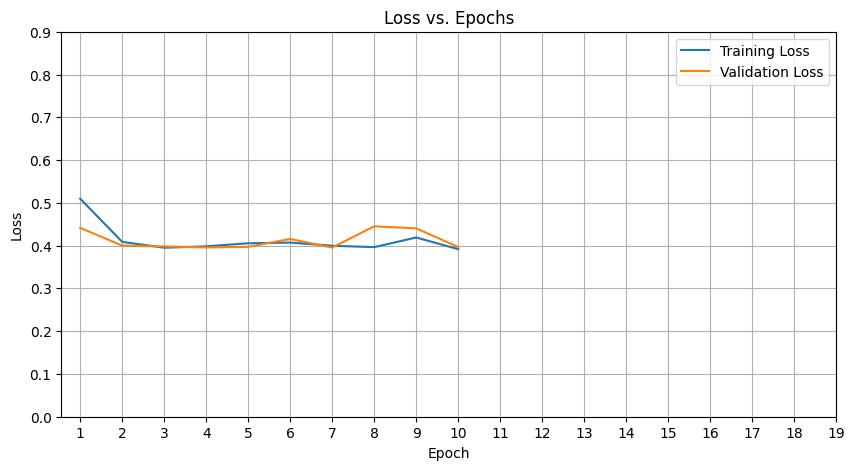

<Figure size 640x480 with 0 Axes>

In [40]:
import numpy as np
def train_model(model, train_loader, val_loader, optimizer, device, epochs=10):
    train_losses = []  # List to store training losses
    val_losses = []
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            masks = masks.squeeze(1)  # Remove channel dimension if necessary

            # Resize outputs to match target mask dimensions
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Calculate loss
            loss = F.cross_entropy(outputs, masks.long())  # Convert masks to Long
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on training and validation data
        train_loss, train_iou, train_dice = evaluate_model(model, train_loader, device)
        val_loss, val_iou, val_dice = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")
        print("-" * 40)
      # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), train_losses[:20], label='Training Loss')
    plt.plot(range(1, 11), val_losses[:20], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 20))  # Set x-axis ticks to integers
    plt.yticks(np.arange(0,1,0.1))  # Set x-axis ticks to integers

    plt.legend()
    plt.grid()
    plt.show()

    plt.savefig('lr4e-2.png')


# Set device and optimizer
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-2)  # Define optimizer

# Train the model
train_model(model, train_loader, val_loader, optimizer, device, epochs=10)

Epoch 1/10
Train Loss: 0.3980, IoU: nan, Dice: nan
Validation Loss: 0.4115, IoU: 0.0001, Dice: 0.0002
----------------------------------------
Epoch 2/10
Train Loss: 0.3822, IoU: 0.0025, Dice: 0.0050
Validation Loss: 0.3944, IoU: 0.0024, Dice: 0.0047
----------------------------------------
Epoch 3/10
Train Loss: 0.3913, IoU: 0.0003, Dice: 0.0005
Validation Loss: 0.3972, IoU: 0.0003, Dice: 0.0005
----------------------------------------
Epoch 4/10
Train Loss: 0.3865, IoU: 0.0063, Dice: 0.0124
Validation Loss: 0.3978, IoU: 0.0064, Dice: 0.0126
----------------------------------------
Epoch 5/10
Train Loss: 0.3990, IoU: 0.0122, Dice: 0.0236
Validation Loss: 0.4116, IoU: 0.0105, Dice: 0.0205
----------------------------------------
Epoch 6/10
Train Loss: 0.3885, IoU: 0.0084, Dice: 0.0164
Validation Loss: 0.3984, IoU: 0.0079, Dice: 0.0155
----------------------------------------
Epoch 7/10
Train Loss: 0.3861, IoU: 0.0006, Dice: 0.0012
Validation Loss: 0.3970, IoU: 0.0005, Dice: 0.0011
----

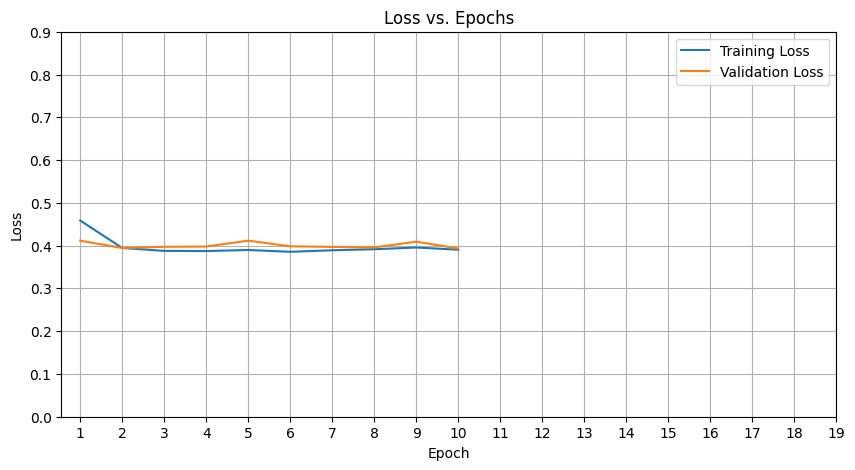

<Figure size 640x480 with 0 Axes>

In [41]:
import numpy as np
def train_model(model, train_loader, val_loader, optimizer, device, epochs=10):
    train_losses = []  # List to store training losses
    val_losses = []
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            masks = masks.squeeze(1)  # Remove channel dimension if necessary

            # Resize outputs to match target mask dimensions
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            # Calculate loss
            loss = F.cross_entropy(outputs, masks.long())  # Convert masks to Long
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on training and validation data
        train_loss, train_iou, train_dice = evaluate_model(model, train_loader, device)
        val_loss, val_iou, val_dice = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")
        print("-" * 40)
      # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), train_losses[:20], label='Training Loss')
    plt.plot(range(1, 11), val_losses[:20], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 20))  # Set x-axis ticks to integers
    plt.yticks(np.arange(0,1,0.1))  # Set x-axis ticks to integers

    plt.legend()
    plt.grid()
    plt.show()

    plt.savefig('lr2e-2.png')


# Set device and optimizer
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)  # Define optimizer

# Train the model
train_model(model, train_loader, val_loader, optimizer, device, epochs=10)